## Задание

Создайте автокодировщик, удаляющий черные квадраты в лучшайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [ ]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np 

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

## Данные

In [ ]:
# Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Нормировка данных
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [ ]:
# Изменение формы под удобную для Keras
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

## Добавление шума (черных квадратов)

In [ ]:
def insert_black_squares(numbers, n=1, square_side=8):
    # deep copy
    squared_numbers = numbers.copy()
    pictures_number = len(squared_numbers)
    
    # n - the number of squares in each picture
    for _ in range(n):
        # itterate over every picture
        for i in tqdm(range(pictures_number)):
            # randomly choose the square of 8 to 8 size
            index_start_horiz = np.random.randint(0, (x_train[0].shape[0] - square_side))
            index_end_horiz = index_start_horiz + square_side

            index_start_vert = np.random.randint(0, (x_train[0].shape[1] - square_side))
            index_end_vert = index_start_vert + square_side

            # paint 8 to 8 square to black color
            squared_numbers[i][index_start_horiz:index_end_horiz,
                               index_start_vert:index_end_vert] = 0
    
    return squared_numbers

In [ ]:
train_noise = insert_black_squares(x_train, n=3)
test_noise = insert_black_squares(x_test, n=3)

100%|██████████| 10000/10000 [00:00<00:00, 140559.79it/s]


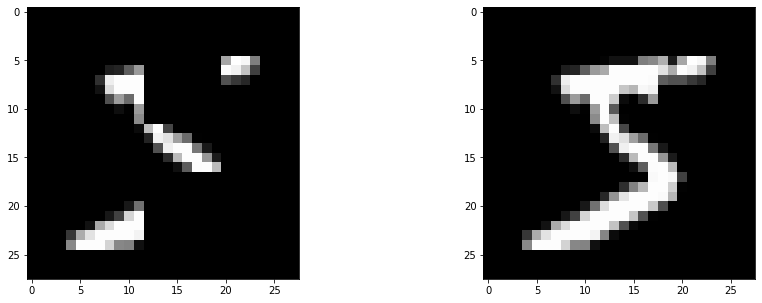

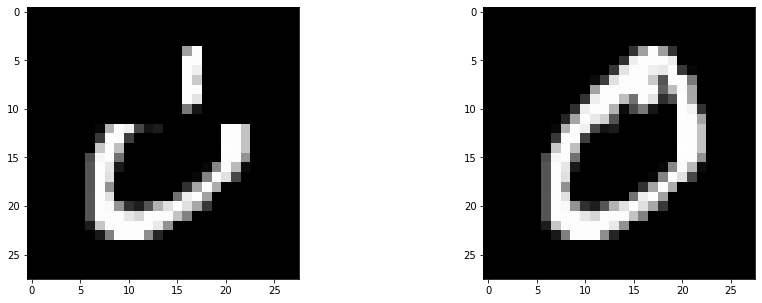

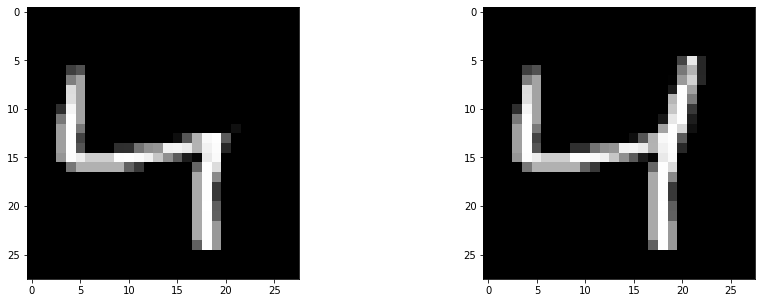

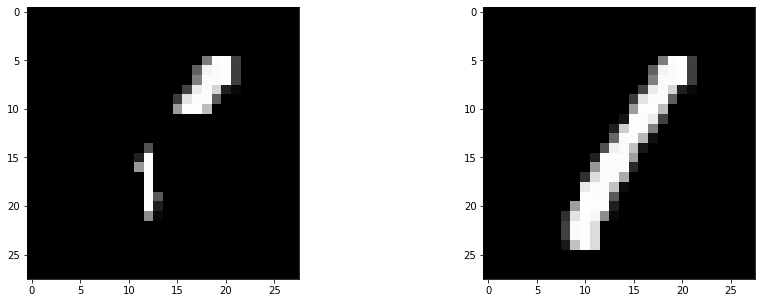

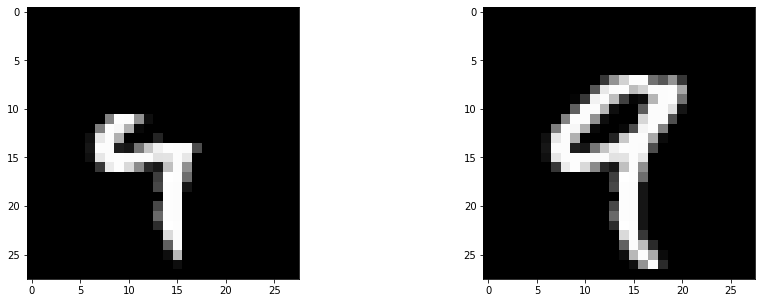

In [ ]:
for i in range(len(train_noise[:5])):
    fig = plt.figure(figsize=(15, 5))
    # Создаем области ax для отрисовки изображений
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)

    ax_1.imshow(train_noise[i].squeeze(axis=-1), cmap='gray')
    ax_2.imshow(x_train[i].squeeze(axis=-1), cmap='gray')
    plt.show()

## Autoencoder

In [ ]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(1, 2, dilation_rate=2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(0.0009),
                loss='mse')

  return model

In [ ]:
# Создание автокодировщика
ae_faces = create_base_ae(x_train.shape[1:])

In [ ]:
# Обучение модели на датасете лиц
ae_faces.fit(train_noise, x_train,
             epochs=15, 
             batch_size=100,
             validation_data=(test_noise, x_test))

Epoch 1/15
600/600 [==============================] - 30s 48ms/step - loss: 0.0250 - val_loss: 0.0238
Epoch 2/15
600/600 [==============================] - 29s 48ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 3/15
600/600 [==============================] - 30s 50ms/step - loss: 0.0096 - val_loss: 0.0134
Epoch 4/15
600/600 [==============================] - 30s 50ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 5/15
600/600 [==============================] - 29s 49ms/step - loss: 0.0080 - val_loss: 0.0092
Epoch 6/15
600/600 [==============================] - 29s 49ms/step - loss: 0.0075 - val_loss: 0.0089
Epoch 7/15
600/600 [==============================] - 30s 49ms/step - loss: 0.0071 - val_loss: 0.0087
Epoch 8/15
600/600 [==============================] - 30s 49ms/step - loss: 0.0067 - val_loss: 0.0090
Epoch 9/15
600/600 [==============================] - 31s 51ms/step - loss: 0.0064 - val_loss: 0.0086
Epoch 10/15
600/600 [==============================] - 30s 50ms/step - loss: 0.006

## Make prediction

In [ ]:
# Получение предсказания автокодировщика на обучающей выборке
pred = ae_faces.predict(x_test)

## Plot results

In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(target_images, noised_images, pred, shape=None, n=4): 
    if shape is None:                               # Автоопределение формы данных
        shape = target_images.shape[1:3]                   # форма изображения 

    plt.figure(figsize=(n*4, n*4), dpi=100)                     # Размер полотна
    plt.subplots_adjust(hspace=0.2, wspace=0.001)

    for i in range(0, n):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из оригинального набора
        ax = plt.subplot(n, 4, 4*i + 1)               # Картинка располагается в верхнем ряду
        plt.imshow(target_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False)
        ax.set_title('Оригинал')

        # Показ шумовой картинки с тем же индексом
        ax = plt.subplot(n, 4, 4*i + 2)           # Картинка располагается в среднем ряду
        plt.imshow(noised_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Зашумлённое изображение')

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(n, 4, 4*i + 3)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Предсказание')

        # Показ разницы предсказания и зашумленной картинки
        ax = plt.subplot(n, 4, 4*i + 4)           # Картинка располагается в нижнем ряду
        plt.imshow(noised_images[index].reshape(shape) - pred[index].reshape(shape),
                   cmap='gray', vmin=-1, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Извлечённый шум')
    
    plt.show()

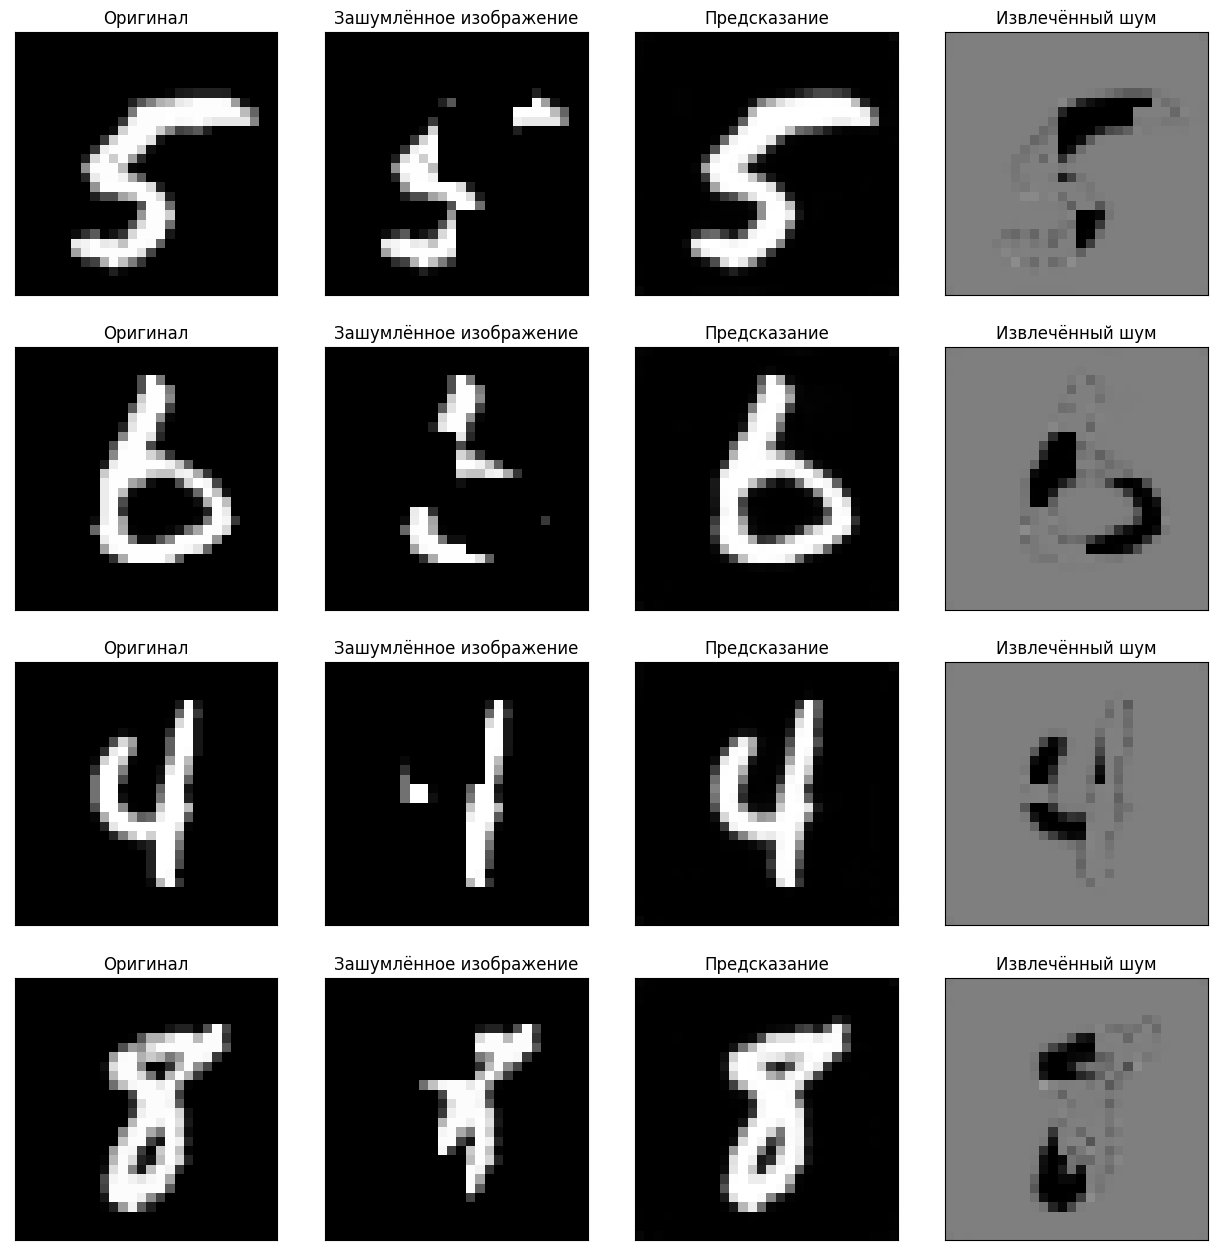

In [ ]:
# Сравнение исходных и восстановленных картинок из обучающей выборки
plot_images(x_test, test_noise, pred)